<a href="https://colab.research.google.com/github/rcpaffenroth/dac_raghu/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [1]:
import glob
import os
import numpy as np
import pandas as pd

In [2]:
data_1d = np.array(pd.read_csv('https://raw.githubusercontent.com/rcpaffenroth/dac_raghu/main/data_1d.txt'))
data_2d = np.array(pd.read_csv('https://raw.githubusercontent.com/rcpaffenroth/dac_raghu/main/data_2d.txt'))

# Some basic plots

In [3]:
import matplotlib.pylab as py

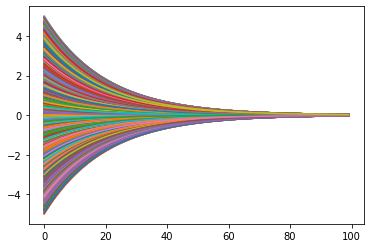

In [4]:
py.plot(data_1d.T);

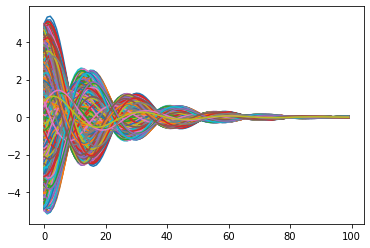

In [5]:
py.plot(data_2d.T);

# Auto-encoder

Based on https://www.kaggle.com/code/sinclairg/pytorch-lightning-tutorial-autoencoders

In [6]:
! pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 54.8 MB/s eta 0:00:00


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pytorch_lightning as pl

In [8]:
encoder = nn.Sequential(nn.Linear(100, 64), 
                        nn.ELU(), 
                        nn.Linear(64, 32), 
                        nn.ELU(), 
                        nn.Linear(32, 2))
decoder = nn.Sequential(nn.Linear(2, 32), 
                        nn.ELU(), 
                        nn.Linear(32, 64),
                        nn.ELU(), 
                        nn.Linear(64, 100))

In [9]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def training_step(self, batch, batch_idx):
        x = batch[0]
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        # Include extra logging here
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.001)
        return optimizer

In [10]:
ae = LitAutoEncoder(encoder, decoder)

In [11]:
dataset = torch.utils.data.TensorDataset(torch.Tensor(data_2d))
train_loader = torch.utils.data.DataLoader(dataset)

In [12]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model=ae, train_dataloaders=train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 8.6 K 
1 | decoder | Sequential | 8.7 K 
---------------------------------------
17.3 K    Trainable params
0         Non-trainable params
17.3 K    Total params
0.069     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [13]:
X =  torch.Tensor(data_2d)
H = encoder(X).detach()
X_hat = decoder(H).detach()

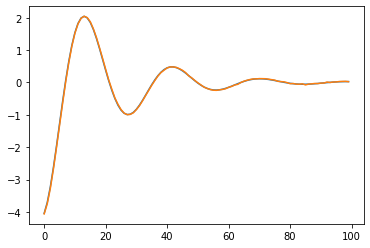

In [14]:
py.plot(X[0,:])
py.plot(X_hat[0,:])

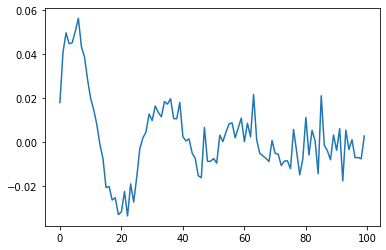

In [15]:
py.plot(X[0,:]-X_hat[0,:])

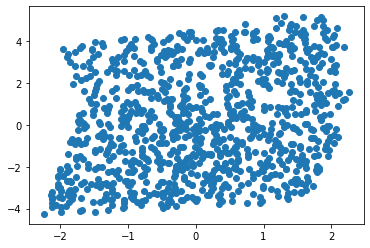

In [16]:
py.scatter(H[:,0], H[:,1])

tensor([-0.9209,  3.2718], grad_fn=<AddBackward0>)


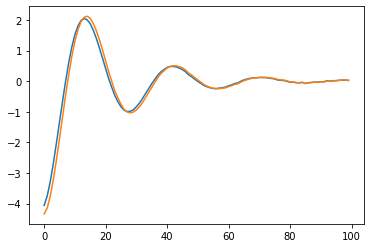

In [17]:
h = encoder(X[0,:])
print(h)
x_hat = decoder(h).detach()
py.plot(x_hat)

x_hat = decoder(h+torch.tensor([0.5, 0.5])).detach()
py.plot(x_hat)


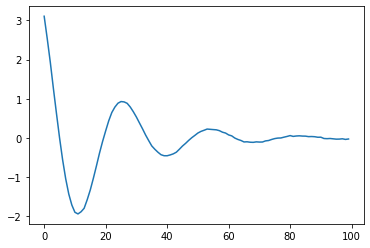

In [18]:
# h = torch.Tensor([2.8186, -2.0229])
h = torch.Tensor([2, -2])
x_hat = decoder(h).detach()
py.plot(x_hat)